In [1]:
import numpy as np
# import scipy.optimize as opt
# import sys, os, random, gzip
import os
import tensorflow as tf
# from keras import backend as K
# from keras.models import *
# from keras.layers import *
# from keras.optimizers import Adam
# from keras.losses import categorical_crossentropy
import keras
from keras import metrics
# from keras.utils import np_utils
# import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

# Data 

In [67]:
import tensorflow_datasets as tfds

# Construct a tf.data.Dataset
ds = tfds.load('mnist', split='train', shuffle_files=True)

# Build your input pipeline
# ds = ds.shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
ds = ds.shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# x = []
# y = []
# for i in range(10):
for example in ds.take(i):
    image, label = example["image"], example["label"]
#         x.append(image)
#         y.append(label)
    

In [43]:
for example in ds.take(3):
    image, label = example["image"], example["label"]

In [68]:
x_train = image
y_train = label

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [167]:
import pandas as pd

In [168]:
data = pd.read_csv("./kc_house_data.csv")

In [169]:
data["id"].array

<PandasArray>
[7129300520, 6414100192, 5631500400, 2487200875, 1954400510, 7237550310,
 1321400060, 2008000270, 2414600126, 3793500160,
 ...
 7852140040, 9834201367, 3448900210, 7936000429, 2997800021,  263000018,
 6600060120, 1523300141,  291310100, 1523300157]
Length: 21613, dtype: int64

In [170]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [173]:
x_rg = data.values

In [18]:
data.head(1).index

RangeIndex(start=0, stop=1, step=1)

In [8]:
dir(data)

['T',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_e

In [175]:
x_rg.shape

(21613, 21)

In [184]:
y_rg = x_rg[:,2]
x_rg = x_rg[:,3:]

In [186]:
x_rg.shape, y_rg.shape

((21613, 18), (21613,))

## Custom Loss Function

In [4]:
class MeanSquaredError(tf.keras.losses.Loss):
    
    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor_v2(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        return tf.reduce_mean(math_ops.square(y_pred - y_true), axis=-1)

## Custom Layer

In [ ]:
class KQV(tf.keras.layers.Layer):
    def __init__(self, units=128):
        super(KQV, self).__init__()
        self.units = units
        
    def build(self, input_shape):  # Create the state of the layer (weights)
        wq_init = tf.random_normal_initializer()
        wk_init = tf.random_normal_initializer()
        wv_init = tf.random_normal_initializer()
        
        self.wq = tf.Variable(initial_value=wq_init(shape=(self.units, input_shape[-2] ), dtype='float32'), trainable=True)
        self.wk = tf.Variable(initial_value=wk_init(shape=(self.units, input_shape[-2] ), dtype='float32'), trainable=True)
        self.wv = tf.Variable(initial_value=wv_init(shape=(self.units, input_shape[-2] ), dtype='float32'), trainable=True)

        
#         b_init = tf.zeros_initializer()
#         self.b = tf.Variable(initial_value=b_init(shape=(self.units,), dtype='float32'), trainable=True)
        
    def call(self, inputs):  # Defines the computation from inputs to outputs
        q = tf.matmul(self.wq,inputs)
        k = tf.matmul(self.wk,inputs)
        v = tf.matmul(self.wv, inputs)

        return k, q, v


In [3]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        
        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        
        return out2

In [433]:
class Symmetry_Set_Basis(tf.keras.layers.Layer):
    def __init__(self, node=7, num_out=1, rank=2):
        super(Symmetry_Set_Basis, self).__init__()
        self.node = node
        self.wq = tf.keras.layers.Dense(node)
        self.wq2 = tf.keras.layers.Dense(node)
        self.wk = tf.keras.layers.Dense(node)
        self.num_out = num_out
        self.p = [[0,2,1],[0,1,3,2], [0,1,2,4,3], [0,1,2,3,5,4]][rank-2]
        self.rui = tf.random_uniform_initializer(minval=-10, maxval=10)
    
    def Tile_reshape(self, cn):
        a = cn.shape
#         a = tf.constant(a)
        b = tf.zeros(tf.rank(cn))+1
        b = tf.cast(b,tf.int32)
        a = tf.concat([b[:-1],b[-1:]*tf.constant(a[-1], tf.int32)], -1)
        return a
    def VP(self, m, cn): # m: order,  cn: input tensor, k: range
#         cn = tf.cast(cn, tf.float64)
        vp = tf.math.pow(cn,m)
        vp = tf.reduce_sum(vp, axis = -1)
        vp = tf.expand_dims(vp, axis = -1)
        vp = tf.tile(vp, self.Tile_reshape(cn))
        return vp
    
    def VC1(self, cn):
        
        vc = tf.reduce_sum(cn, axis = -1)
        vc = tf.expand_dims(vc, axis=-1)
        vc = tf.tile(vc, self.Tile_reshape(cn))
#         vc = tf.cast(vc, tf.float64)
        return vc
    def VC2(self, cn):
        vc = (self.VC1(cn)**2 - self.VP(2, cn))/2
        return vc
    def VC3(self, cn):
        vc1 = self.VC1(cn)
        vp2 = self.VP(2,cn)
        vp3 = self.VP(3,cn)
        vc = (vc1**3-vp3-3*(vp2 * vc1-vp3 ))/6
        return vc
    def VC4(self, cn):
        vc = (self.VC3(cn)*self.VP(1,cn) - self.VC2(cn)*self.VP(2,cn) + self.VC1(cn)*self.VP(3,cn) - self.VP(4,cn) )/4
        return vc
    
    def call(self, q, k, v):
#         out_num = self.order*2
#         v = tf.expand_dims(v, axis = -1)
#         v = tf.tile(v, self.Tile_reshape(out_num))
        vc1 = self.VC1(v)
        vc2 = self.VC2(v)
        vc3 = self.VC3(v)
        vc4 = self.VC4(v)
        vp2 = self.VP(2,v)
        vp3 = self.VP(3,v)
        vp4 = self.VP(4,v)
        print("v shape:", v.shape)
        print("vc shape:", vc1.shape)
##--------------------------------------------------------
        vc2 = tf.math.pow(tf.math.abs(vc2),1/2)*tf.math.sign(vc2)
        vc3 = tf.math.pow(tf.math.abs(vc3),1/3)*tf.math.sign(vc3)
        vc4 = tf.math.pow(tf.math.abs(vc4),1/4)*tf.math.sign(vc4)
        vp2 = tf.math.pow(tf.math.abs(vp2),1/2)*tf.math.sign(vp2)
        vp3 = tf.math.pow(tf.math.abs(vp3),1/3)*tf.math.sign(vp3)
        vp4 = tf.math.pow(tf.math.abs(vp4),1/4)*tf.math.sign(vp4)


##----------------------------------------------------------


        vc1 = tf.expand_dims(vc1, axis=-1)
        vc2 = tf.expand_dims(vc2, axis=-1)
        vc3 = tf.expand_dims(vc3, axis=-1)
        vc4 = tf.expand_dims(vc4, axis=-1)
        vp2 = tf.expand_dims(vp2, axis=-1)
        vp3 = tf.expand_dims(vp3, axis=-1)
        vp4 = tf.expand_dims(vp4, axis=-1)

        v = tf.concat([vc1, vc2, vc3, vc4, vp2, vp3, vp4], axis =-1)
        print("v shape:", v.shape)
#         v = tf.Variable(self.rui(shape = tf.shape(v)), dtype=tf.float32)*v
        

        q = tf.expand_dims(q, axis=-1)
#         print("q shape:", q.shape)

        q = self.wq(q)
#         print("q shape:", q.shape)
        q = tf.transpose(q, perm=self.p) 
#         print("q shape:", q.shape)

        k = self.wk(v)
#         print("k shape:", k.shape)
#         print("wk",k)
        k = tf.transpose(k, perm=self.p) 
#         print("k shape:", k.shape)
#         n = tf.matmul(q,k) ##tooooooooooo slow
#         print("k",k)
#         print("q",q)
##--------------------------------------------------------------------normalize----------
#         k = tf.math.log(tf.math.abs(k+1e-10)+1)
#         q = tf.math.log(tf.math.abs(q+1e-10)+1)

#         print("kdiv",tf.reduce_sum(tf.math.pow(k,2) ,axis=-1))

        k = k/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(k,2) ,axis=-1))+1e-10, axis=-1)
        q = q/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(q,2) ,axis=-1))+1e-10, axis=-1)
#         print("k",k)
#         print("q",q)
##-----------------------------------------------------------------------------------------
        n = tf.math.multiply_no_nan(k,q)
#         n = k*q
#         print("n shape:", n.shape)

#         print("v shape:", v.shape)
##--------------------------------------------------sum all v*n version ------------------------------------------
        n = tf.transpose(n, perm=self.p)
        print("v shape:", v.shape)
        print("n shape:", n.shape)
        v = tf.math.multiply_no_nan(n,v)
#         v = v*n

#         n = tf.reduce_sum(n, axis=-1)
#         v = tf.reduce_max(v, axis=-2)
#         v = tf.reduce_sum(v, axis=-2)
        v = tf.reduce_sum(v, axis=-1)

##-----------------------------------------------top k version------------------------------
#         pn = tf.math.top_k(n, k = self.num_out)
#         n = pn.values
#         index = pn.indices
#         v = tf.gather(v,index, batch_dims=-1)
##------------------------------------------------------------------------------------------------




#         print("v shape:", v.shape)
        return v
        


        
        


In [366]:
class Operator_Basis(tf.keras.layers.Layer):
    def __init__(self, node=3, num_out=1, rank=2):
        super(Operator_Basis, self).__init__()
        self.node = node
        self.wq = tf.keras.layers.Dense(node)
        self.wq2 = tf.keras.layers.Dense(node)
        self.wk = tf.keras.layers.Dense(node)
        self.alpha = tf.keras.layers.Dense(1)
        self.num_out = num_out
        self.p = [[0,2,1],[0,1,3,2], [0,1,2,4,3], [0,1,2,3,5,4]][rank-2]
    
    def call(self, q, k, v):
        sqrt = tf.math.sqrt(tf.math.abs(v)+1e-10)
        ln = tf.math.log(tf.math.abs(v)+1)
#         exp = tf.math.exp(v)
        rgsn = self.alpha(tf.expand_dims(v, axis=-1))
        
        sqrt= tf.expand_dims(sqrt, axis=-1)
        ln = tf.expand_dims(ln, axis=-1)
#         exp = tf.expand_dims(exp, axis=-1)

#         v = tf.concat([sqrt, ln, exp, rgsn], axis =-1)
        v = tf.concat([sqrt, ln, rgsn], axis =-1)

        q = tf.expand_dims(q, axis=-1)
        q = self.wq(q)
        q = tf.transpose(q, perm=self.p) 
        k = self.wk(v)
        k = tf.transpose(k, perm=self.p) 
        
        k = k/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(k,2)+1e-10 ,axis=-1)), axis=-1)
        q = q/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(q,2)+1e-10 ,axis=-1)), axis=-1)
    

#         n = k*q
        n = tf.math.multiply_no_nan(k,q)

#         n = tf.reduce_sum(n, axis=-1)
#         print("n shape:", n.shape)
#         print("v shape:", v.shape)
        n = tf.transpose(n, perm=self.p) 
#         print("n shape:", n.shape)


#         v = tf.reduce_max(v, axis=-2)
#         print("v shape:", v.shape)

##--------------------------------------------------sum all v*n version ------------------------------------------
        v = tf.math.multiply_no_nan(n,v)
#         v = v*n
#         v = tf.reduce_sum(v, axis=-2)
        v = tf.reduce_sum(v, axis=-1)

##----------------------------------------------------------------------------------------------
#         v = tf.reduce_sum(v, axis=-2)
#         pn = tf.math.top_k(n, k = self.num_out)
#         n = pn.values
#         index = pn.indices
#         v = tf.gather(v,index, batch_dims=-1)
        return v
        


        
        


In [260]:
class Data_Selection(tf.keras.layers.Layer):
    def __init__(self, node=1000, num_out=100, rank=2):
        super(Data_Selection, self).__init__()
        self.node = node
        self.wq = tf.keras.layers.Dense(node)
        self.wq2 = tf.keras.layers.Dense(node)
        self.wk = tf.keras.layers.Dense(node)
        self.num_out = num_out
        self.p = [[0,2,1],[0,1,3,2], [0,1,2,4,3], [0,1,2,3,5,4]][rank-2]
    def call(self, q, k, v):
        q = tf.expand_dims(q, axis=-1)
        q = self.wq(q)
        q = tf.transpose(q, perm=self.p) 
#         print("q shape:", q.shape)
        k = tf.expand_dims(k, axis=-1)
        k = self.wk(k)
        k = tf.transpose(k, perm=self.p) 
        k = k/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(k,2)+1e-10 ,axis=-1)), axis=-1)
        q = q/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(q,2)+1e-10 ,axis=-1)), axis=-1)
        n = k*q
##------------------------------------------------------------
        n = tf.transpose(n, perm=self.p)
        print("n shape:", n.shape)
        v = tf.expand_dims(v, axis=-1)
        v = n*v
        v = tf.reduce_sum(v, axis=-2)
        print("v shape:", v.shape)

##-----------------------------------------------------
#         n = tf.reduce_sum(n, axis=-1)
#         pn = tf.math.top_k(n, k = self.num_out)
#         n = pn.values
#         index = pn.indices
#         v = tf.gather(v,index, batch_dims=-1)
        return v

In [170]:
tf.zeros(tf.rank(x))+1

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>

In [149]:
tf.zeros()+1

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>

In [4]:
x_train.shape

(60000, 28, 28)

In [20]:
np.sum(x_train, axis = -1).shape

(60000, 28)

In [262]:
d = np.sum(np.sum(x_train, axis = -1), axis=-1)
d=np.expand_dims(d, axis=-1)
d=np.expand_dims(d, axis=-1)

x_train = x_train/d

In [ ]:
# x_(t+1) = x_t - lr*grad.(f(x_t))

opt = tf.keras.optimizers.Adam(learning_rate=0.1)
var1 = tf.Variable(10.0)
loss = lambda: (var1 ** 2)/2.0       # d(loss)/d(var1) == var1
step_count = opt.minimize(loss, [var1]).numpy()
# The first step is `-learning_rate*sign(grad)`
var1.numpy()

In [346]:
x = x_rg[15:16]
Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x,x,x), x

v shape: (1, 18)
vc shape: (1, 18)
v shape: (1, 18, 7)
wk tf.Tensor(
[[[ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2

(<tf.Tensor: shape=(1, 18), dtype=float32, numpy=
 array([[9.7922925e+17, 8.0966167e+17, 7.1021882e+18, 7.6290285e+18,
         6.0524301e+17, 0.0000000e+00, 8.0966167e+17, 8.0966167e+17,
         1.5553235e+18, 6.7042557e+18, 5.9927380e+18, 6.7037515e+18,
         0.0000000e+00, 1.0603152e+19, 3.0297832e+18, 3.9428487e+18,
         6.7817976e+18, 7.4061943e+18]], dtype=float32)>,
 array([[ 4.00000e+00,  3.00000e+00,  2.95000e+03,  5.00000e+03,
          2.00000e+00,  0.00000e+00,  3.00000e+00,  3.00000e+00,
          9.00000e+00,  1.98000e+03,  9.70000e+02,  1.97900e+03,
          0.00000e+00,  9.81260e+04,  4.75714e+01, -1.22375e+02,
          2.14000e+03,  4.00000e+03]], dtype=float32))

In [427]:
## tf.keras.backend.set_floatx('float32')
inputs = tf.keras.Input(shape=(18))
x = inputs
print(x.shape)
# x = tf.keras.layers.BatchNormalization()(x)
# print(x.shape)


x = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
print(x.shape)

x = Operator_Basis(num_out=1,rank=tf.rank(x))(x, x, x)
print(x.shape)
x = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
print(x.shape)
x = Operator_Basis(num_out=1,rank=tf.rank(x))(x, x, x)
print(x.shape)

# x = Operator_Basis(num_out=1,rank=tf.rank(x))(x, x, x)
# print(x.shape)
# x = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# print(x.shape)

# x = Operator_Basis(num_out=1,rank=tf.rank(x))(x, x, x)
# print(x.shape)
# x = tf.keras.layers.Dense(32)(x)
x = tf.keras.layers.Dense(1)(x)
modelANN = tf.keras.Model(inputs= inputs, outputs=x, name='ANN')

(None, 18)
v shape: (None, 18)
vc shape: (None, 18)
v shape: (None, 18, 7)
v shape: (None, 18, 7)
n shape: (None, 18, 7)
(None, 18)
(None, 18)
v shape: (None, 18)
vc shape: (None, 18)
v shape: (None, 18, 7)
v shape: (None, 18, 7)
n shape: (None, 18, 7)
(None, 18)
(None, 18)


In [ ]:
## tf.math.is_nan()

In [286]:
np.any(np.isnan(x_rg))

False

In [428]:
model_type = "ANN"
save_dir = './test1/'
model_name = '%s_model_'% model_type 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
csv_logger = keras.callbacks.CSVLogger(save_dir+model_type+'.csv')


earlystop = keras.callbacks.EarlyStopping(
                            monitor="val_loss",
                            min_delta=1e-4,
                            patience=3, # 10
                            verbose=1,
                            mode='min', baseline=None, ## 'min' 
                            restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=2, min_lr=0.00001)
callbacks = [checkpoint, csv_logger,  earlystop ]

In [429]:
loss_fn = tf.keras.losses.MeanSquaredError()
# modelANN.compile(optimizer='adam' , loss=loss_fn, metrics=['accuracy', metrics.AUC(name="auc")])
modelANN.compile(optimizer='adam',
                 loss=loss_fn,
                 metrics=['accuracy'])
modelANN.summary()

Model: "ANN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_83 (InputLayer)        [(None, 18)]              0         
_________________________________________________________________
symmetry__set__basis_116 (Sy (None, 18)                70        
_________________________________________________________________
operator__basis_48 (Operator (None, 18)                20        
_________________________________________________________________
symmetry__set__basis_117 (Sy (None, 18)                70        
_________________________________________________________________
operator__basis_49 (Operator (None, 18)                20        
_________________________________________________________________
dense_673 (Dense)            (None, 1)                 19        
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________

In [337]:
## x_rg = np.array(x_rg)
y_rg = np.array(y_rg)

In [338]:
x_rg = x_rg.astype(np.float32)
y_rg = y_rg.astype(np.float32)

In [430]:

modelANN.fit(np.log(np.abs(x_rg)+1), np.log(np.abs(y_rg)+1), callbacks = callbacks, shuffle=True , epochs=10, batch_size=32, verbose=1)
# modelANN.fit(np.log(np.abs(x_rg)+1), np.log(np.abs(y_rg)+1), epochs=10)

Epoch 1/10
v shape: (None, 18)
vc shape: (None, 18)
v shape: (None, 18, 7)
v shape: (None, 18, 7)
n shape: (None, 18, 7)
v shape: (None, 18)
vc shape: (None, 18)
v shape: (None, 18, 7)
v shape: (None, 18, 7)
n shape: (None, 18, 7)
v shape: (None, 18)
vc shape: (None, 18)
v shape: (None, 18, 7)
v shape: (None, 18, 7)
n shape: (None, 18, 7)
v shape: (None, 18)
vc shape: (None, 18)
v shape: (None, 18, 7)
v shape: (None, 18, 7)
n shape: (None, 18, 7)
676/676 [==============================] - 6s 8ms/step - loss: 0.2474 - accuracy: 1.3881e-04
Epoch 2/10
676/676 [==============================] - 5s 8ms/step - loss: 0.0513 - accuracy: 0.0000e+00
Epoch 3/10
676/676 [==============================] - 5s 8ms/step - loss: 0.0370 - accuracy: 0.0000e+00
Epoch 4/10
676/676 [==============================] - 5s 8ms/step - loss: 0.0323 - accuracy: 0.0000e+00
Epoch 5/10
676/676 [==============================] - 5s 8ms/step - loss: 0.0342 - accuracy: 0.0000e+00
Epoch 6/10
676/676 [====================

In [431]:
y_pre = modelANN.predict(np.log(np.abs(x_rg)+1))

v shape: (None, 18)
vc shape: (None, 18)
v shape: (None, 18, 7)
v shape: (None, 18, 7)
n shape: (None, 18, 7)
v shape: (None, 18)
vc shape: (None, 18)
v shape: (None, 18, 7)
v shape: (None, 18, 7)
n shape: (None, 18, 7)


In [386]:
import matplotlib.pyplot as plt


In [425]:
y_pre

array([[0.5294644 ],
       [0.46715382],
       [0.5347007 ],
       ...,
       [0.5334146 ],
       [0.5299744 ],
       [0.5346126 ]], dtype=float32)

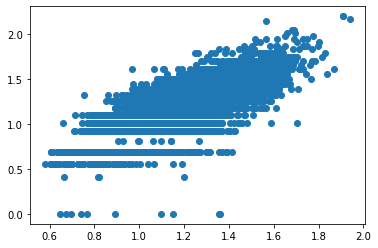

In [436]:
# plt.hist(y_pre, histtype='step')
# plt.hist(np.log(np.abs(y_rg)+1), histtype='step' )
plt.scatter(y_pre,np.log(np.abs(y_rg)+1))
# plt.xlim([0,2.5])
plt.show()


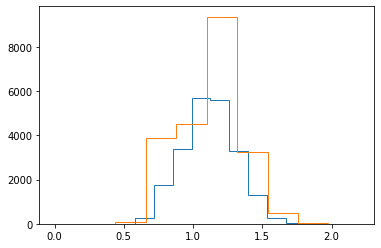

In [437]:
plt.hist(y_pre, histtype='step')
plt.hist(np.log(np.abs(y_rg)+1), histtype='step' )
# plt.xlim([0,2.5])
plt.show()

In [162]:
tf.keras.backend.set_floatx('float32')
inputs = tf.keras.Input(shape=(28,28))
x = inputs
# x = tf.cast(x, tf.float64)
print(x.shape)

x = tf.keras.layers.Flatten()(x)
print(x.shape)
# x = tf.keras.layers.Flatten()(x)
# print(x.shape)
x = Data_Selection(node = 100, num_out=20,rank=tf.rank(x))(x,x,x)
print(x.shape)

# a = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# b = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# c = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# x = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# x = tf.squeeze(x, axis=-1)
# a = tf.squeeze(a, axis=-1)
# b = tf.squeeze(b, axis=-1)
# c = tf.squeeze(c, axis=-1)
# print("a:",a.shape)
# print(x.shape)
# a = tf.concat([x,a], axis=-1)
# b = tf.concat([x,b], axis=-1)
# c = tf.concat([x,c], axis=-1)
# print("a:",a.shape)

# a = Operator_Basis(num_out=1,rank=tf.rank(a))(a, a, a)
# b = Operator_Basis(num_out=1,rank=tf.rank(b))(b, b, b)
# c = Operator_Basis(num_out=1,rank=tf.rank(c))(c, c, c)
# print("a:",a.shape)
# a = tf.squeeze(a, axis=-1)

# x = tf.concat([x,a], axis=-1)
# b = tf.concat([b,c], axis=-1)
# print(x.shape)
# x = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# b = Symmetry_Set_Basis(num_out=1, rank=tf.rank(b))(b, b, b)
# x = tf.squeeze(x, axis=-1)
# b = tf.squeeze(b, axis=-1)
# print(x.shape)
# x = Operator_Basis(num_out=1,rank=tf.rank(x))(x, x, x)
# b = Operator_Basis(num_out=1,rank=tf.rank(b))(b, b, b)
# print(x.shape)
# x = tf.concat([x,b], axis=-1)
# print(x.shape)

x = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
print(x.shape)

x = Operator_Basis(num_out=1,rank=tf.rank(x))(x, x, x)
print(x.shape)

# x = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# a = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# b = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# print(x.shape)


# x = Operator_Basis(num_out=1,rank=tf.rank(x))(x, x, x)
# a = Operator_Basis(num_out=1,rank=tf.rank(a))(a, a, a)
# b = Operator_Basis(num_out=1,rank=tf.rank(b))(b, b, b)
# print(x.shape)
# x = tf.concat([x,a,b], axis=-1)
# print(x.shape)








# x = tf.keras.layers.Dense(256)(x)
# print(x.shape)
# x = tf.keras.layers.Dense(128)(x)
# print(x.shape)
# x = tf.keras.layers.Dense(32)(x)
# print(x.shape)
x = tf.keras.layers.Dense(10)(x)
print(x.shape)
x = tf.keras.layers.Activation("softmax")(x)
print(x.shape)
modelANN = tf.keras.Model(inputs= inputs, outputs=x, name='ANN')

(None, 28, 28)
(None, 784)
n shape: (None, 784, 100)
v shape: (None, 100)
(None, 100)
v shape: (None, 100, 7)
n shape: (None, 100, 7)
(None, 100)
(None, 100)
(None, 10)
(None, 10)


In [163]:
model_type = "ANN"
save_dir = './test1/'
model_name = '%s_model_'% model_type 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
csv_logger = keras.callbacks.CSVLogger(save_dir+model_type+'.csv')


earlystop = keras.callbacks.EarlyStopping(
                            monitor="val_loss",
                            min_delta=1e-4,
                            patience=3, # 10
                            verbose=1,
                            mode='min', baseline=None, ## 'min' 
                            restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=2, min_lr=0.00001)
callbacks = [checkpoint, csv_logger,  earlystop ]

In [164]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [165]:
# modelANN.compile(optimizer='adam' , loss=loss_fn, metrics=['accuracy', metrics.AUC(name="auc")])
modelANN.compile(optimizer='adam',
                 loss=loss_fn,
                 metrics=['accuracy'])
modelANN.summary()

Model: "ANN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 784)               0         
_________________________________________________________________
data__selection_16 (Data_Sel (None, 100)               400       
_________________________________________________________________
symmetry__set__basis_45 (Sym (None, 100)               70        
_________________________________________________________________
operator__basis_30 (Operator (None, 100)               30        
_________________________________________________________________
dense_342 (Dense)            (None, 10)                1010      
_________________________________________________________________
activation_29 (Activation)   (None, 10)                0       

In [306]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [118]:
y_train.shape


(60000,)

In [53]:
vec = np.zeros([10])

In [54]:
vec

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [69]:
y2[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [99]:
# y = [ for i in y_train]
y2 = []
for i in y_train:
    vec = np.zeros([10])    
    vec[i]=1
    y2.append(vec)
y2=np.array(y2)    
y2.shape


(60000, 10)

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [107]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [166]:

# modelANN.fit(x_train, y2 , callbacks = callbacks, shuffle=True , epochs=400, batch_size=32, verbose=1)
modelANN.fit(x_train, y_train, epochs=4)

Epoch 1/4
n shape: (32, 784, 100)
v shape: (32, 100)
v shape: (32, 100, 7)
n shape: (32, 100, 7)
n shape: (32, 784, 100)
v shape: (32, 100)
v shape: (32, 100, 7)
n shape: (32, 100, 7)
1875/1875 [==============================] - 54s 29ms/step - loss: 2.1954 - accuracy: 0.2388
Epoch 2/4
1875/1875 [==============================] - 54s 29ms/step - loss: 2.1695 - accuracy: 0.2695
Epoch 3/4
1875/1875 [==============================] - 54s 29ms/step - loss: 2.1632 - accuracy: 0.2755
Epoch 4/4
1875/1875 [==============================] - 53s 29ms/step - loss: 2.1611 - accuracy: 0.2781


In [ ]:
# Selection Block
class Selection(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(Selection, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        
#         self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        
        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights


## Optimize

In [13]:
# x_(t+1) = x_t - lr*grad.(f(x_t))

opt = tf.keras.optimizers.Adam(learning_rate=0.1)
var1 = tf.Variable(10.0)
loss = lambda: (var1 ** 2)/2.0       # d(loss)/d(var1) == var1
step_count = opt.minimize(loss, [var1]).numpy()
# The first step is `-learning_rate*sign(grad)`
var1.numpy()

9.9

In [45]:
while var1.numpy()>0.1:
    opt.minimize(loss, [var1]).numpy()
    print(var1.numpy())

0.9540412
0.9305041
0.90742856
0.8848088
0.862639
0.8409134
0.8196262
0.79877156
0.7783437
0.7583367
0.73874485
0.7195623
0.70078325
0.68240196
0.66441256
0.64680934
0.6295866
0.6127385
0.59625936
0.5801435
0.5643853
0.54897904
0.5339191
0.5191999
0.50481594
0.4907616
0.47703144
0.46361995
0.4505217
0.43773136
0.4252435
0.41305286
0.40115413
0.3895421
0.3782116
0.36715743
0.35637453
0.34585783
0.33560234
0.3256031
0.3158552
0.30635378
0.29709405
0.28807122
0.2792806
0.2707176
0.26237753
0.25425592
0.24634825
0.23865008
0.23115706
0.22386485
0.21676919
0.20986587
0.20315073
0.1966197
0.19026873
0.18409383
0.1780911
0.17225665
0.16658668
0.16107745
0.15572527
0.1505265
0.14547755
0.14057492
0.13581514
0.13119482
0.12671058
0.12235916
0.11813731
0.11404186
0.11006968
0.10621771
0.102482945
0.09886242


In [53]:
a = tf.constant([[1,1],[2,2],[3,3]])
a.numpy()

array([[1, 1],
       [2, 2],
       [3, 3]], dtype=int32)

In [55]:
tf.math.pow(a,2)

<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
array([[1, 1],
       [4, 4],
       [9, 9]], dtype=int32)>

In [57]:
tf.reduce_sum(a, axis=-1)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([2, 4, 6], dtype=int32)>

# 

## Symmetry Variables Function

In [132]:
## Note: m<=n
def find_N(cn):
    a = cn.shape
    a = tf.constant(a)
    n = a[-1:].numpy()
    n = n[0]
    return n

def Tile_reshape(cn):
    a = cn.shape
    a = tf.constant(a)
    b = a*0+1
    a = tf.concat([b[:-1],b[-1:]*tf.constant(a[-1])], -1)
    return a
def VP(m, cn): # m: order,  cn: input tensor, k: range
    cn = tf.cast(cn, tf.float64)
    vp = tf.math.pow(cn,m)
    vp = tf.reduce_sum(vp, axis = -1)
    vp = tf.expand_dims(vp, axis = -1)
    vp = tf.tile(vp, Tile_reshape(cn))
    return vp
 
def VC1(cn):
    vc = tf.reduce_sum(cn, axis = -1)
    vc = tf.expand_dims(vc, axis=-1)
    vc = tf.tile(vc, Tile_reshape(cn))
    vc = tf.cast(vc, tf.float64)
    return vc
def VC2(cn):
    vc = (VC1(cn)**2 - VP(2, cn))/2
    return vc
def VC3(cn):
    vc1 = VC1(cn)
    vp2 = VP(2,cn)
    vp3 = VP(3,cn)
    vc = (vc1**3-vp3-3*(vp2 * vc1-vp3 ))/6
    return vc
def VC4(cn):
    n = find_N(cn)
#     vc = (VC3(cn)*VP(0,cn) - 3/(n-2)*VC2(cn)*VP(1,cn) + 3/(n-2)*2/(n-1)*VC1(cn)*VP(3,cn) - 3/(n-2)*2/(n-1)*VP(4,cn) )/(n-3)
    vc = (VC3(cn)*VP(1,cn) - VC2(cn)*VP(2,cn) + VC1(cn)*VP(3,cn) - VP(4,cn) )/4
    return vc

## VCN: 
# vcn = 0
# for i in range(N):
#     vcn += VC(N-i-1)VP(i+1)*(-1)**i
# vcn = vcn/N

In [130]:
def Con(n,k):
    fc=1
    for i in range(k):
        fc *=(n-i)
        fc /= (i+1)
    return fc
def text(cn):
    vc = (VC2(cn)*VP(1, cn) - VC1(cn)*VP(2,cn) + VP(3,cn))/3
    return vc

In [120]:
Con(5,3)

10.0

In [58]:
VC3(cn).dtype

tf.float64

In [92]:
a = cn.shape
a = tf.constant(a)
n = a[-1:].numpy()
n[0]

5

In [134]:
text(cn)

<tf.Tensor: shape=(3, 5), dtype=float64, numpy=
array([[ 225.,  225.,  225.,  225.,  225.],
       [  10.,   10.,   10.,   10.,   10.],
       [1175., 1175., 1175., 1175., 1175.]])>

In [135]:
VC3(cn)

<tf.Tensor: shape=(3, 5), dtype=float64, numpy=
array([[ 225.,  225.,  225.,  225.,  225.],
       [  10.,   10.,   10.,   10.,   10.],
       [1175., 1175., 1175., 1175., 1175.]])>

In [128]:
cn = tf.constant([[1,2,3,4,5],[1,1,1,1,1],[3,4,5,6,7]])
# cn = tf.constant([[1,2,3,4],[1,1,1,1],[3,4,5,6]])

# cn.numpy()
VC4(cn).numpy()

array([[ 561.5,  561.5,  561.5,  561.5,  561.5],
       [   5. ,    5. ,    5. ,    5. ,    5. ],
       [3616.5, 3616.5, 3616.5, 3616.5, 3616.5]])

In [112]:
N=5
fc=1
for i in range(N):
    fc*=(i+1)
    
a = 0
for i in range(N):
    a += fc/(i+1)

In [113]:
a

274.0

In [52]:
tf.math.multiply(VC3(cn),VC1(cn))

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a double tensor but is a int32 tensor [Op:Mul]

In [26]:
a = cn.shape
a = tf.constant(a)
b = a*0+1
a = tf.concat([b[:-1],b[-1:]*tf.constant(a[-1])], -1)
a

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2], dtype=int32)>

In [22]:
a[-1:]

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>

In [11]:
tf.tile(cn, [1,2])

<tf.Tensor: shape=(3, 4), dtype=int32, numpy=
array([[1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3]], dtype=int32)>